### Predicting HDB Prices with Random Forest Regressor

Having collected the data, wrangled it together, done exploratory data analysis, we will now begin to model the data to predict HDB prices. 

In this notebook, we will be using an XGBoost Regressor for prediction - a highly efficient and scalable implementation of the gradient boosting algorithm. 

#### Brief Recap on Random Forest 
- **Features**
  - Ensemble Method
    - Combines multiple decision trees to produce a more robust and accurate model.
  - Bagging Technique
    - Each tree is built from a bootstrap sample (a random sample with replacement) of the training data.
  - Reduction of Overfitting
    - By averaging the results of individual trees, it reduces the risk of overfitting compared to a single decision tree.
  - Highly Scalable
    - Efficiently handles large datasets with thousands of input variables without variable deletion.
  - Feature Importance
    - Can provide insights into the relative importance of each feature in the prediction.
- **Mechanism**
  - Decision Trees
    - Constructs a multitude of decision trees at training time.
  - Random Subsets
    - Each tree is trained on a random subset of the data and features.
  - Averaging
    - Predictions are made by averaging the results of all the individual decision trees.
- **Advantages**
  - Performance
    - Often performs well with default parameters and requires little hyperparameter tuning.
  - Robustness
     - Handles outliers and noise well due to averaging of results.
  - Versatility
    - Can handle both numerical and categorical data and can model complex interactions between variables.
    - Random forests do not require scaling of the data. 
    - Since they use decision trees that split the data based on feature thresholds, the absolute scale of the features does not matter.
    - Standardizing the features is also not necessary for random forests. 
    - The algorithm is not sensitive to the variance in the data.
    - Random forests are quite robust to features with different ranges. Since each feature is considered independently in the trees' splits, the range of one feature does not affect the others.
- **Disadvantages**
  - Interpretability
    - More difficult to interpret than a single decision tree.
  - Computationally Intensive
    - Can require significant computation and memory resources, especially with very large numbers of trees.
  - Model Size
    - The final model can be quite large and may take up substantial memory.

#### Load Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Train Test Split
from sklearn.model_selection import train_test_split, cross_validate

# Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import mean_absolute_error, r2_score
import scipy.stats as stats

#### Load data into DataFrame and Remove Unwanted Columns

In [2]:
# Make file path variable so that all we need is to change this if we move notebook location
file_path = '../data/processed/final_HDB_for_model.parquet.gzip'

# Read data into csv
df = pd.read_parquet(file_path)

# Check to see if it loaded correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890376 entries, 0 to 890375
Data columns (total 27 columns):
 #   Column                                                                         Non-Null Count   Dtype         
---  ------                                                                         --------------   -----         
 0   town                                                                           890376 non-null  object        
 1   flat_type                                                                      890376 non-null  object        
 2   block                                                                          890376 non-null  object        
 3   street_name                                                                    890376 non-null  object        
 4   storey_range                                                                   890376 non-null  object        
 5   floor_area_sqm                                                          

In [3]:
# Put all columns to be deleted into a list
drop_cols = ['block', 'street_name','address','sold_year_month']

# Drop columns
df = df.drop(columns=drop_cols)

#### Creating a Pipeline 
Pipelines in machine learning are useful because they streamline the entire process of preparing data and building models. Most importantly, they make things repeatable without human error! 

In [4]:
# Create lists of the categorical and numerical columns allowing them to be treated differently
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns


In [5]:
# Create instances of OneHotEncoder
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Create a pipeline to apply transformation
prepoc = make_column_transformer(
    (cat_transformer, cat_cols),
    remainder='passthrough'
)

# View Pipeline
prepoc

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object'))])

#### Train Test Split the Data 

In [6]:
# Select target column
target_col = 'resale_price'

# Ready X and y
X = df.loc[:, ~df.columns.isin([target_col])]
y = df[target_col]


In [7]:
# Split the data, 80-20 split with a random state included for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 54)


In [8]:
# Create final pipeline with model
pipe = make_pipeline(prepoc, RandomForestRegressor(verbose=4))

# View Pipeline
pipe


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object'))])),
                ('randomforestregressor', RandomForestRegressor(verbose=4))])

#### Train and Fit Baseline RandomForestRegressor Model

In [9]:
# Fit model
pipe.fit(X_train, y_train)


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:  3.9min


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed: 15.6min


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['town', 'flat_type', 'storey_range', 'flat_model', 'most_closest_mrt'], dtype='object'))])),
                ('randomforestregressor', RandomForestRegressor(verbose=4))])

In [10]:
pipe.steps[1][1]

RandomForestRegressor(verbose=4)

In [11]:
# R2 score on training set
r2_baseline_train = pipe.score(X_train, y_train)

# MAE for training
y_pred = pipe.predict(X_train)
mae_baseline_train = mean_absolute_error(y_train, y_pred)

# Print scores to assess
print("Training r2 score =", round(r2_baseline_train, 4))
print("Training MAE score =", round(mae_baseline_train, 2))


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   34.2s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:   34.5s


Training r2 score = 0.9974
Training MAE score = 5706.56


In [12]:
# R2 score on testing set
r2_baseline_test = pipe.score(X_test, y_test)

# MAE for testing
y_pred = pipe.predict(X_test)
mae_baseline_test = mean_absolute_error(y_test, y_pred)

# Print scores to assess
print("Test r2 score =", round(r2_baseline_test, 4))
print("Test MAE score =", round(mae_baseline_test, 2))


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    8.3s


Test r2 score = 0.9818
Test MAE score = 15027.17


#### Save Baseline Model

In [13]:
#Saving Baseline model
import pickle
with open('../models/randomForest_240129.pkl', 'wb') as file:
    pickle.dump(pipe, file)


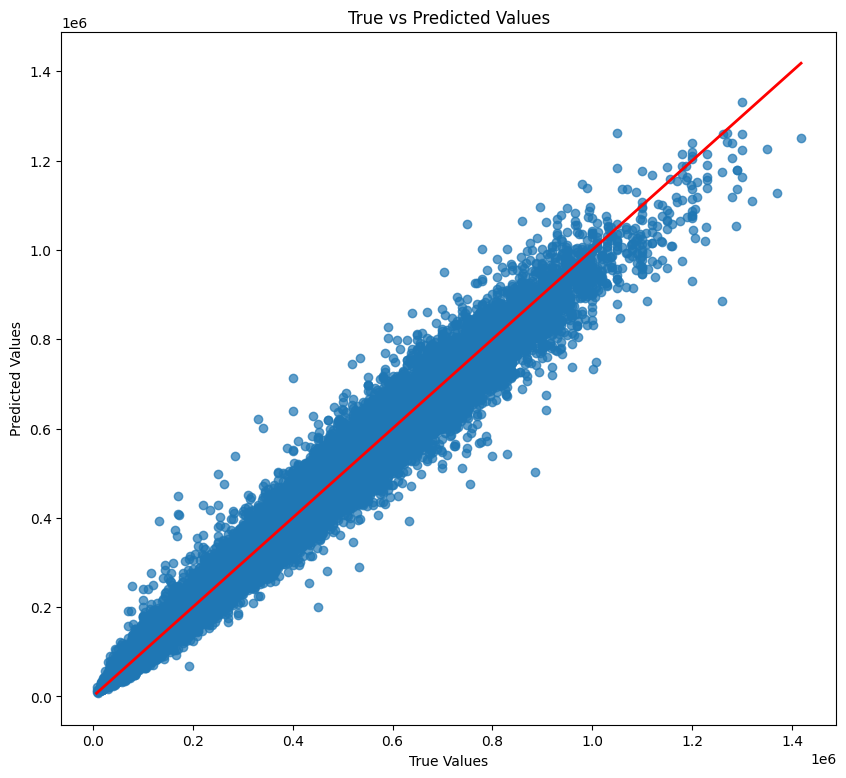

In [14]:
# plot model performance
plt.figure(figsize=(10, 9))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

**comments**
- The concentration of points is closer to the red line in the lower value range and starts to disperse as the value increases.
- There is a noticeable pattern where the predicted values tend to be lower than the true values as the magnitude increases, especially beyond approximately 1 million, suggesting a potential underestimation by the model for higher true values.




